# Test the Simple atmospheric transparency Emulator

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/02/10
- last update : 2023/10/24


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

- access to data see https://setuptools.pypa.io/en/latest/userguide/datafiles.html

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
import seaborn as sns
import copy

from importlib.resources import files

In [2]:
from simpleemulator.simpleatmemulator import SimpleAtmEmulator,find_data_path
from simpleemulator.simpleatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
FLAG_CHECKWITHLIBRADTRAN = False

In [6]:
AIRMASSMIN=1.0
AIRMASSMAX=2.6
DAM = 0.2
airmasses = np.arange(AIRMASSMIN,AIRMASSMAX,DAM)
NAM=len(airmasses)

In [7]:
PWVMIN = 0
PWVMAX = 11
DPWV = 0.5
pwvs = np.arange(PWVMIN,PWVMAX,DPWV)
NPWV = len(pwvs)

In [8]:
pwvs

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5])

In [9]:
OZMIN = 0
OZMAX = 600
DOZ   = 50
ozs = np.arange(OZMIN,OZMAX,DOZ)
NOZ = len(ozs)

In [10]:
ozs

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550])

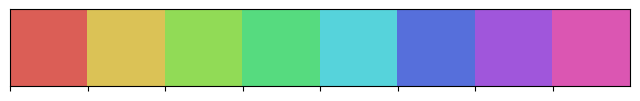

In [11]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

# Check emulator

In [12]:
#path_data =  find_data_path()  
#print("path_data = ",path_data)
#print(path_data)

In [13]:
emul = SimpleAtmEmulator()

Observatory LSST found in preselected observation sites


In [14]:
WL = emul.GetWL()

## Check emulator with Rayleigh scattering

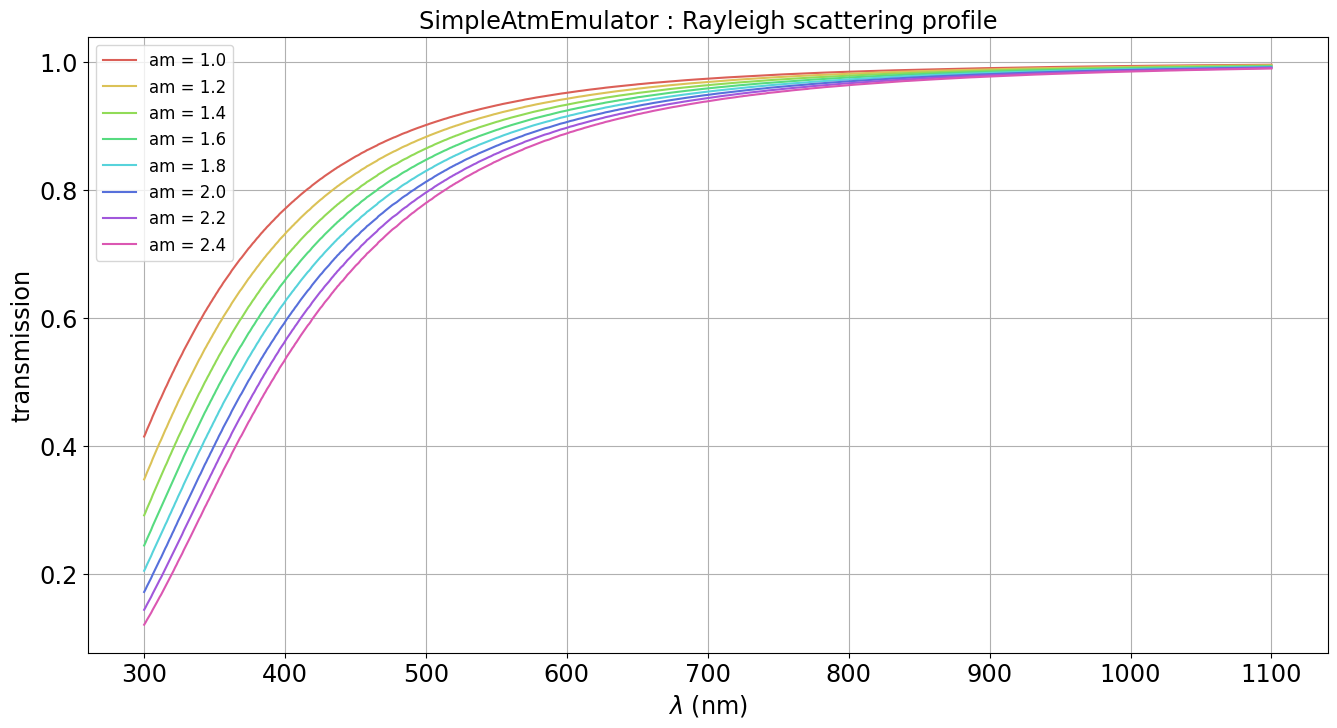

In [15]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):
    label = f"am = {am:.1f}" 
    transm = emul.GetRayleighTransparencyArray(WL,am)
    ax.plot(WL,transm,color=hls_colors[idx],label=label)
title = f"SimpleAtmEmulator : Rayleigh scattering profile"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with Oxygen O2 absorption

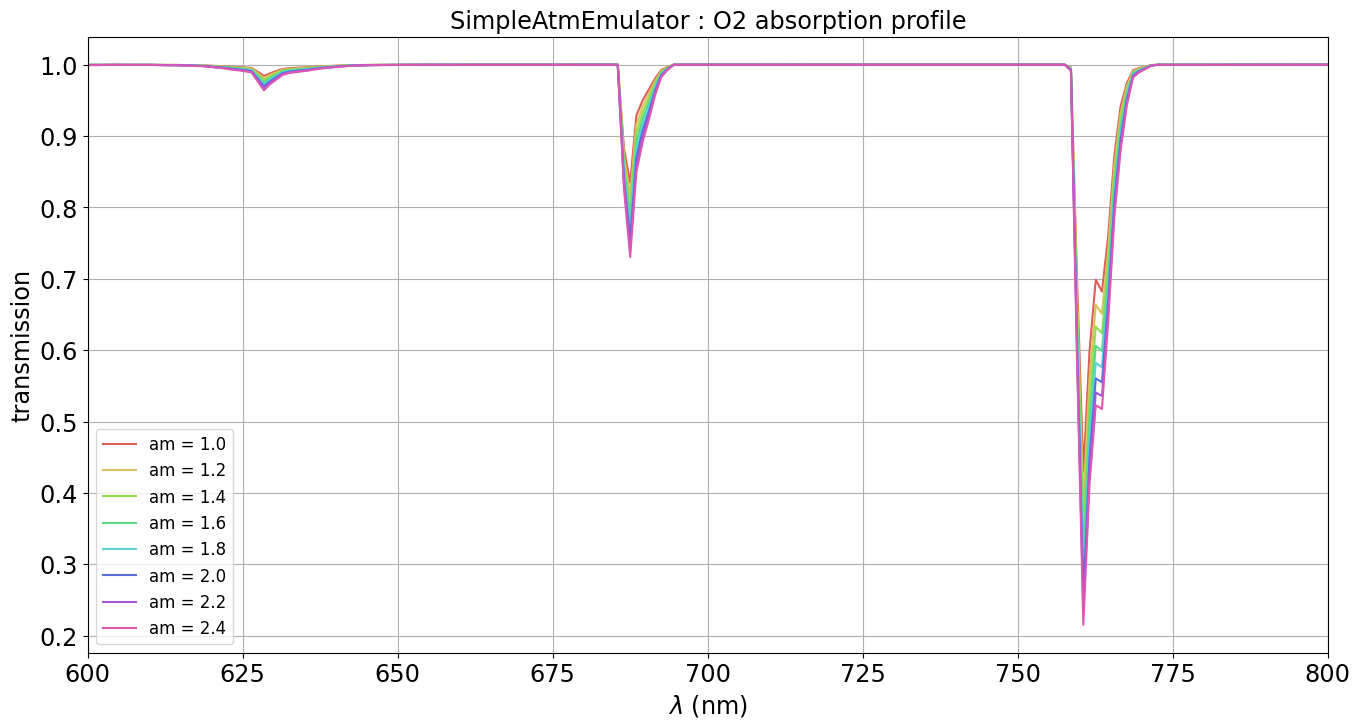

In [16]:
fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):
    transm = emul.GetO2absTransparencyArray(WL,am)
    label = f"am = {am:.1f}" 
    ax.plot(WL,transm,color=hls_colors[idx],label=label)
title = f"SimpleAtmEmulator : O2 absorption profile"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(600.,800.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with PWV absorption

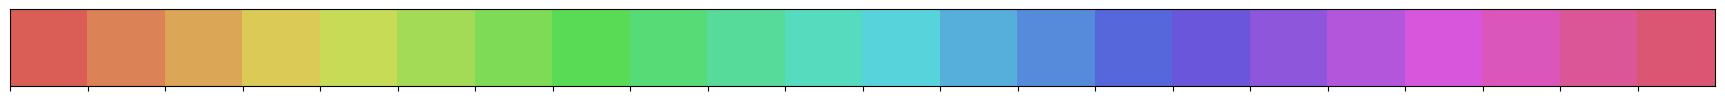

In [17]:
hls_colors = sns.color_palette("hls", NPWV)
sns.palplot(hls_colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


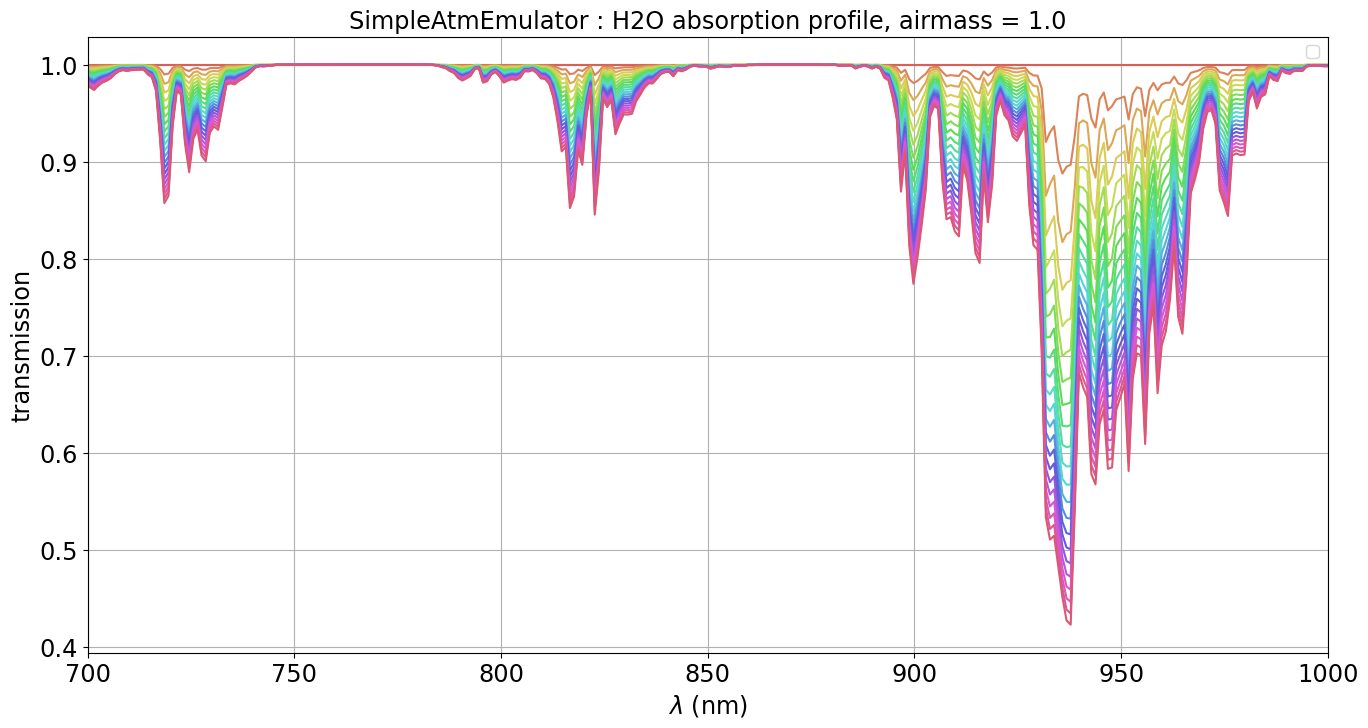

In [18]:
am = 1
fig, ax = plt.subplots()

for idx,pwv in enumerate(pwvs):

    transm = emul.GetPWVabsTransparencyArray(WL,am,pwv)
    ax.plot(WL,transm,color=hls_colors[idx])
    
title = f"SimpleAtmEmulator : H2O absorption profile, airmass = {am:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(700.,1000.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with Ozone absorption

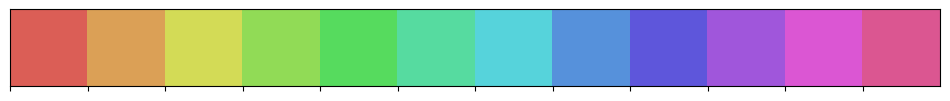

In [19]:
hls_colors = sns.color_palette("hls", NOZ)
sns.palplot(hls_colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


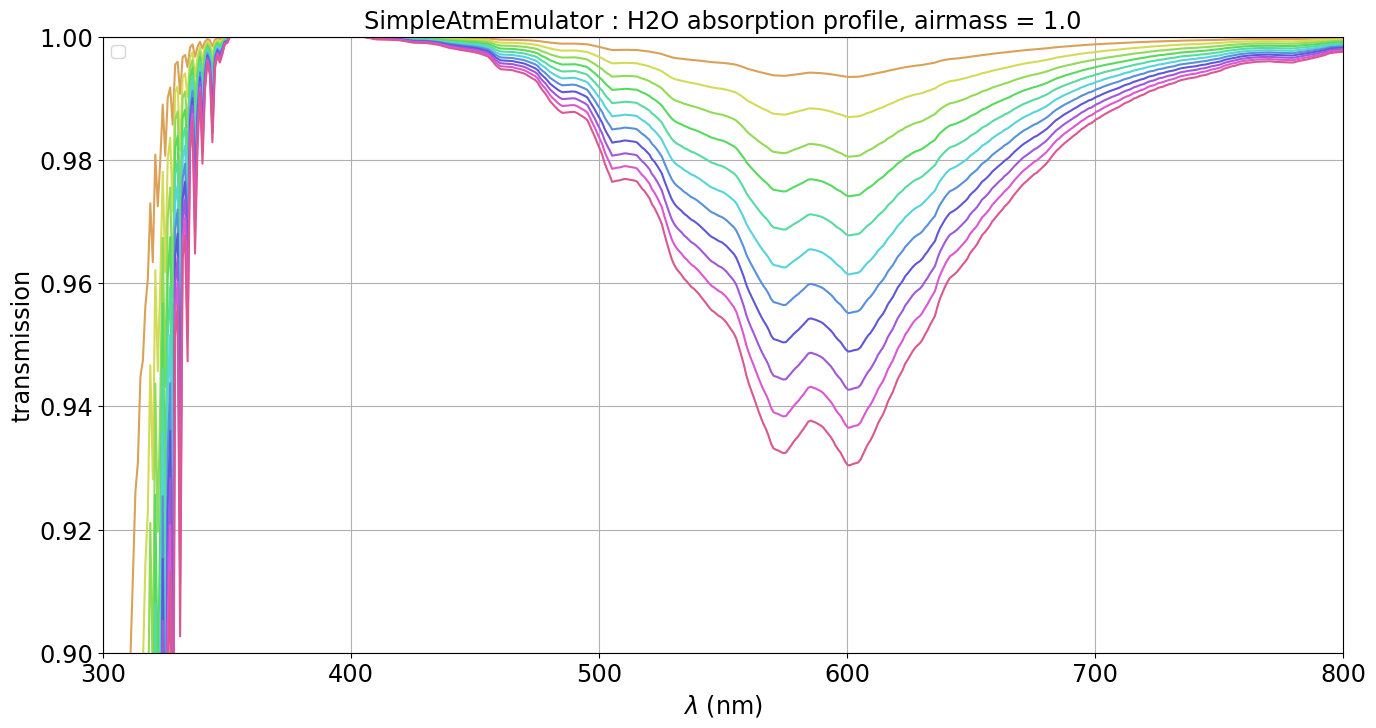

In [20]:
am =1

fig, ax = plt.subplots()

for idx,oz in enumerate(ozs):

    transm = emul.GetOZabsTransparencyArray(WL,am,oz)
    ax.plot(WL,transm,color=hls_colors[idx])
    
itle = f"SimpleAtmEmulator : Ozone absorption profile, am = {am:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(300.,800.)
ax.set_ylim(0.9,1.0)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Check emulator with combined ascattering and absorption process and check with libradtran

In [21]:
am0 = 1.0
pwv0 = 5.0
oz0 = 500.
transm1 = emul.GetGriddedTransparencies(WL,am0,pwv0,oz0,flagRayleigh=True)
label1=f"emulator : airmass = {am0:.2f}, pwv  = {pwv0:.2f} mm , oz = {oz0:.1f} DU"

In [22]:
am1 = 2.0
pwv1 = 5.0
oz1 = 500.
transm2 = emul.GetGriddedTransparencies(WL,am1,pwv1,oz1,flagRayleigh=True)
label2=f"emulator : airmass = {am1:.2f},  pwv  = {pwv1:.2f} mm , oz = {oz1:.1f} DU"

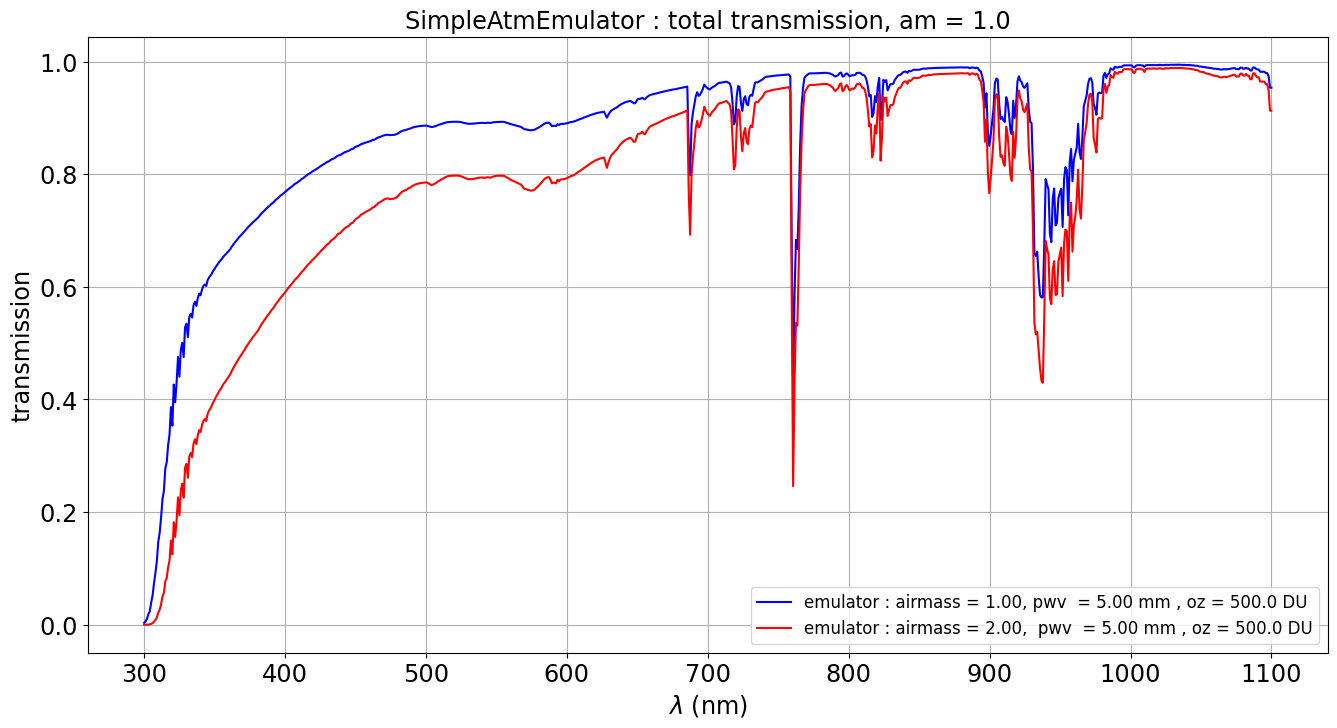

In [23]:
fig, ax = plt.subplots()

ax.plot(WL,transm1,'b-',label=label1)
ax.plot(WL,transm2,'r-',label=label2)

title = f"SimpleAtmEmulator : total transmission, am = {am0:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()


In [24]:
if FLAG_CHECKWITHLIBRADTRAN:
    path,thefile = libsimulateVisible.ProcessSimulation(am0,pwv0,oz0,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data1 = np.loadtxt(os.path.join(path,thefile))
    path,thefile = libsimulateVisible.ProcessSimulation(am1,pwv1,oz1,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
    data2 = np.loadtxt(os.path.join(path,thefile))

In [25]:
if FLAG_CHECKWITHLIBRADTRAN:
    plt.figure(figsize=(14,8))
    plt.plot(WL,transm1,'b-',label=label0)
    plt.plot(data1[:,0],data1[:,1],'k:',label="librandtran")
    plt.plot(WL,transm2,'r-',label=label1)
    plt.plot(data2[:,0],data2[:,1],'k-.',label="libradtran")
    plt.legend()

## Check with aerosols

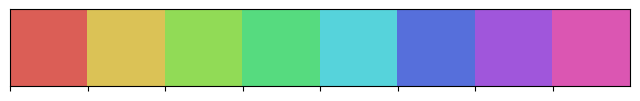

In [26]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


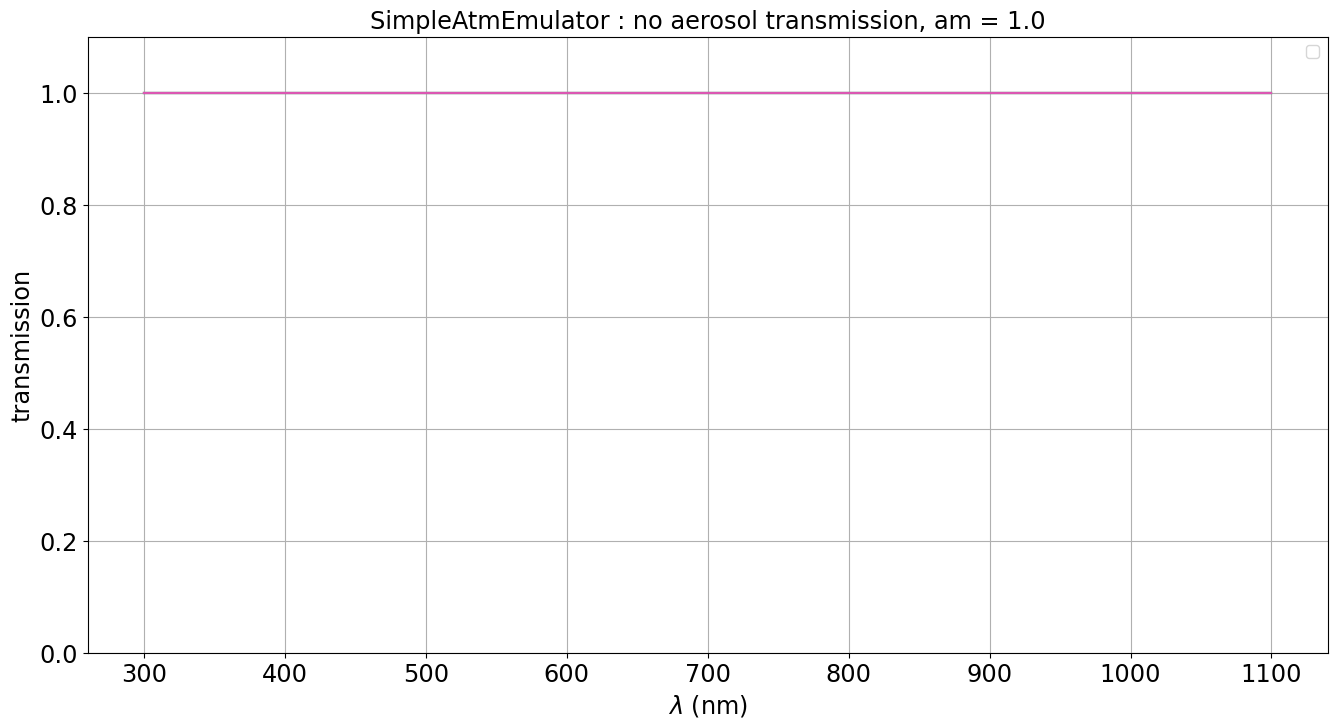

In [27]:
ncomp=0

fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp)
    ax.plot(WL,transm,color=hls_colors[idx])
    
ax.set_ylim(0,1.1)

title = f"SimpleAtmEmulator : no aerosol transmission, am = {am0:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

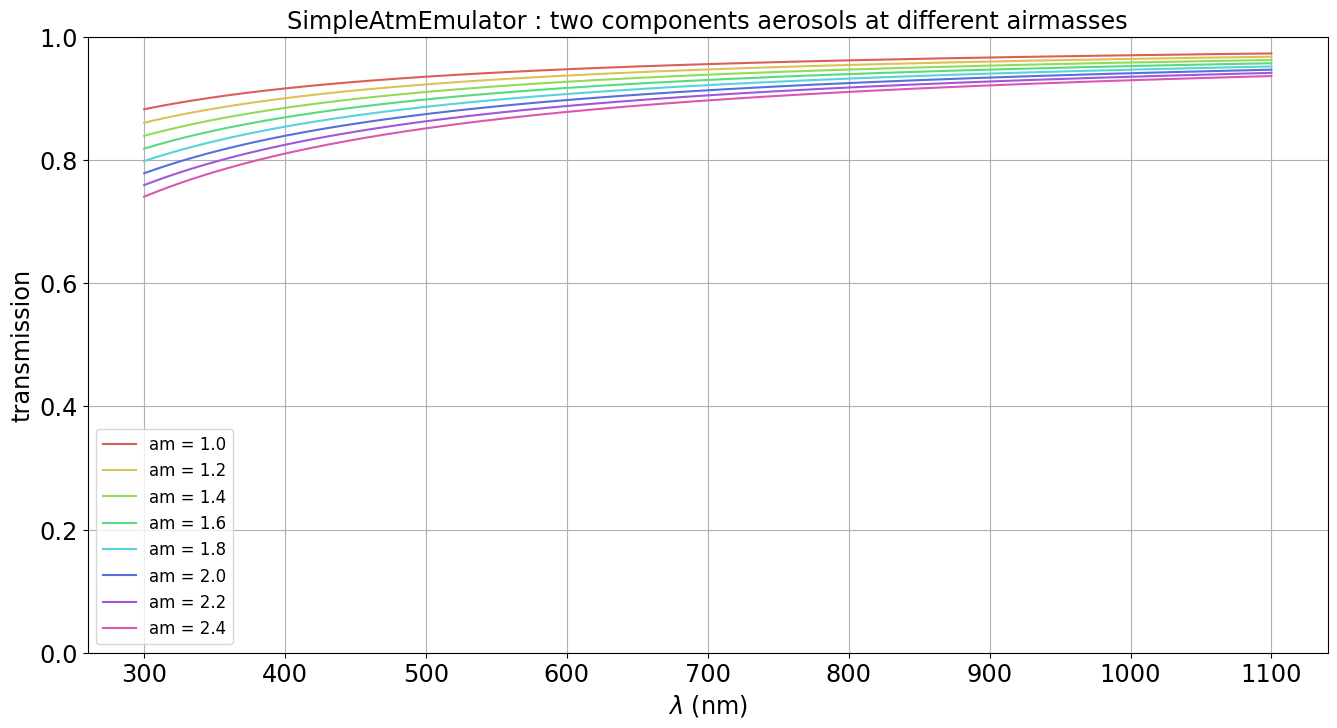

In [28]:
taus = [0.05, 0.01]
betas = [- 1.0, -2]
ncomp=2

fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    label = f"am = {am:.1f}"
    ax.plot(WL,transm,color=hls_colors[idx],label=label)
    
ax.set_ylim(0,1)
title = f"SimpleAtmEmulator : two components aerosols at different airmasses"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

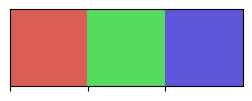

In [29]:
all_taus = [0.01, 0.05, 0.1]
betas = [- 1.0]
beta = betas[0]
ncomp=1
am=1

NTAUS = len(all_taus)

hls_colors = sns.color_palette("hls", NTAUS)
sns.palplot(hls_colors)

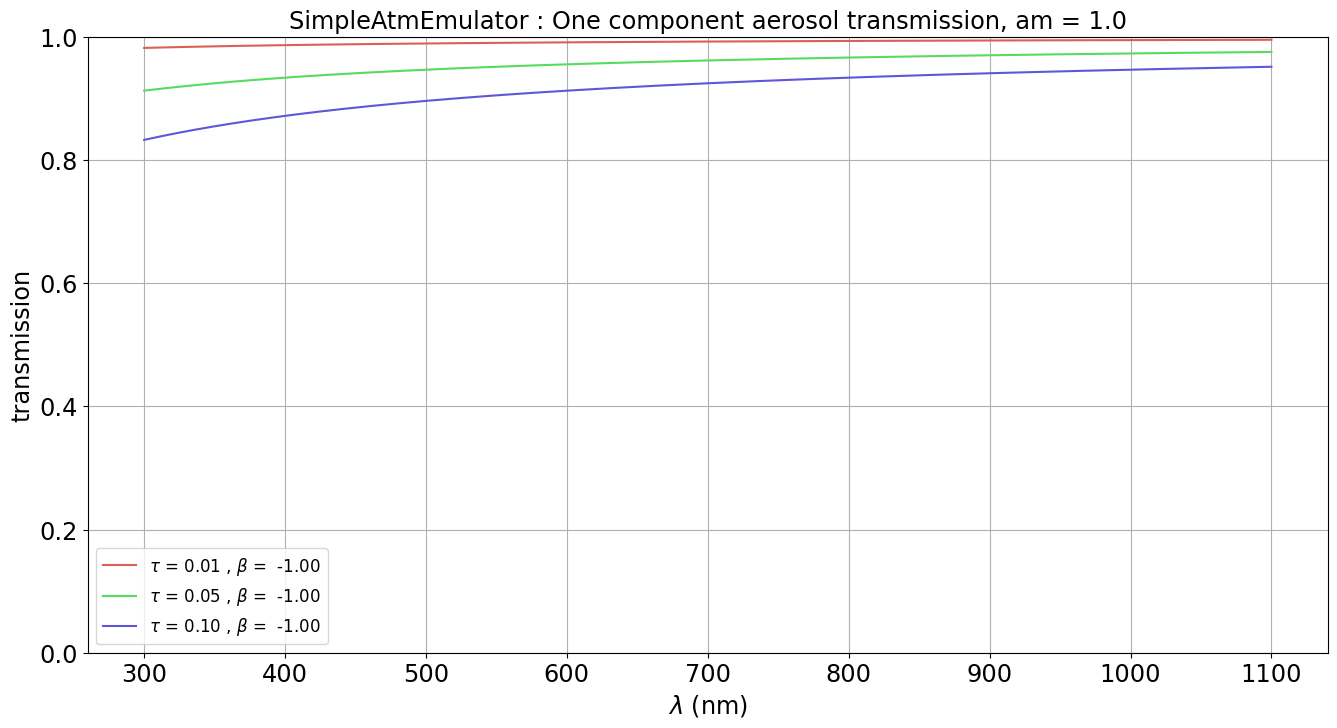

In [30]:
am  = 1

fig, ax = plt.subplots()
for idx,tau in enumerate(all_taus):
    taus = [tau]
    label = f"$\\tau$ = {tau:.2f} , $\\beta$ =  {beta:.2f}"
    transm = emul.GetAerosolsTransparencies(WL,am,ncomp,taus,betas)
    ax.plot(WL,transm,color=hls_colors[idx],label=label)
    
ax.set_ylim(0,1)
title = f"SimpleAtmEmulator : One component aerosol transmission, am = {am0:.1f}"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

## Test all combined transmission

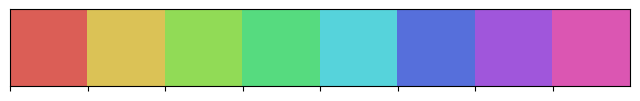

In [31]:
hls_colors = sns.color_palette("hls", NAM)
sns.palplot(hls_colors)

### Without aerosols

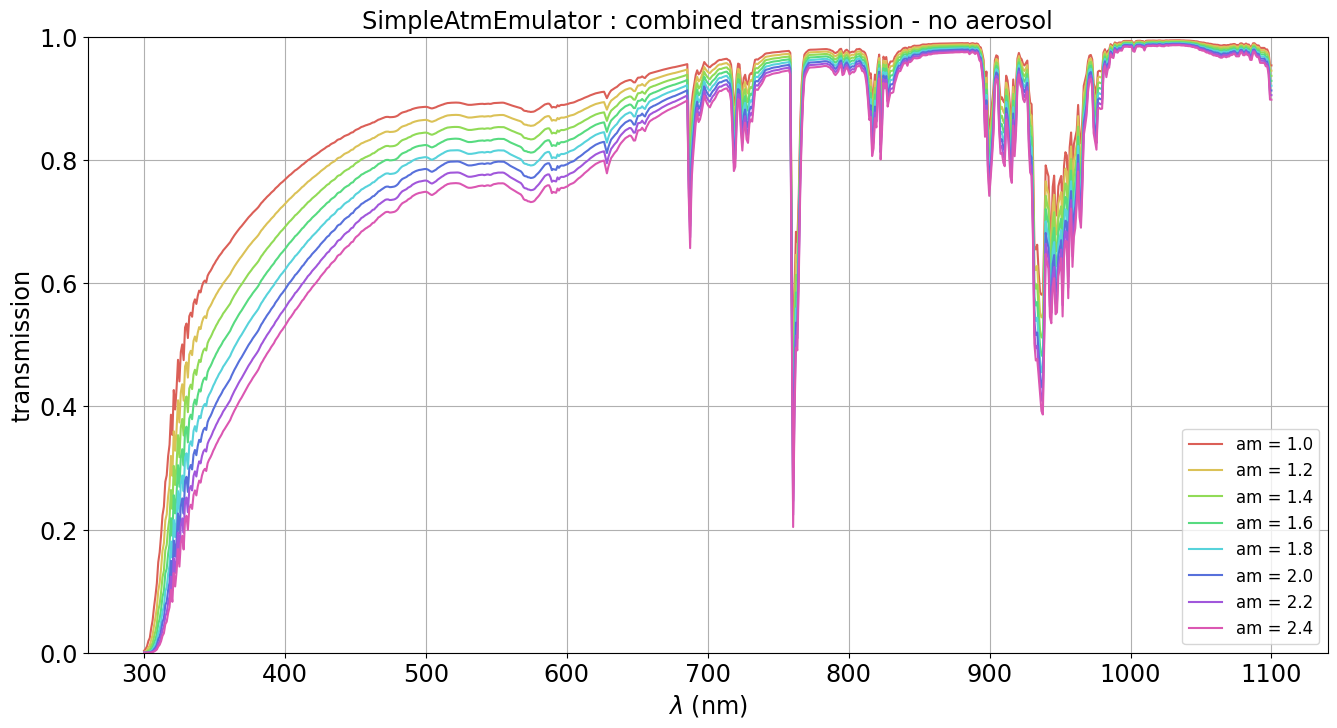

In [32]:
pwv0 = 5.0
oz0 = 500.

fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    label = f"am = {am:.1f}"
    ax.plot(WL,transm,color=hls_colors[idx],label=label)
    
ax.set_ylim(0,1)
title = f"SimpleAtmEmulator : combined transmission - no aerosol"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

### With aerosols

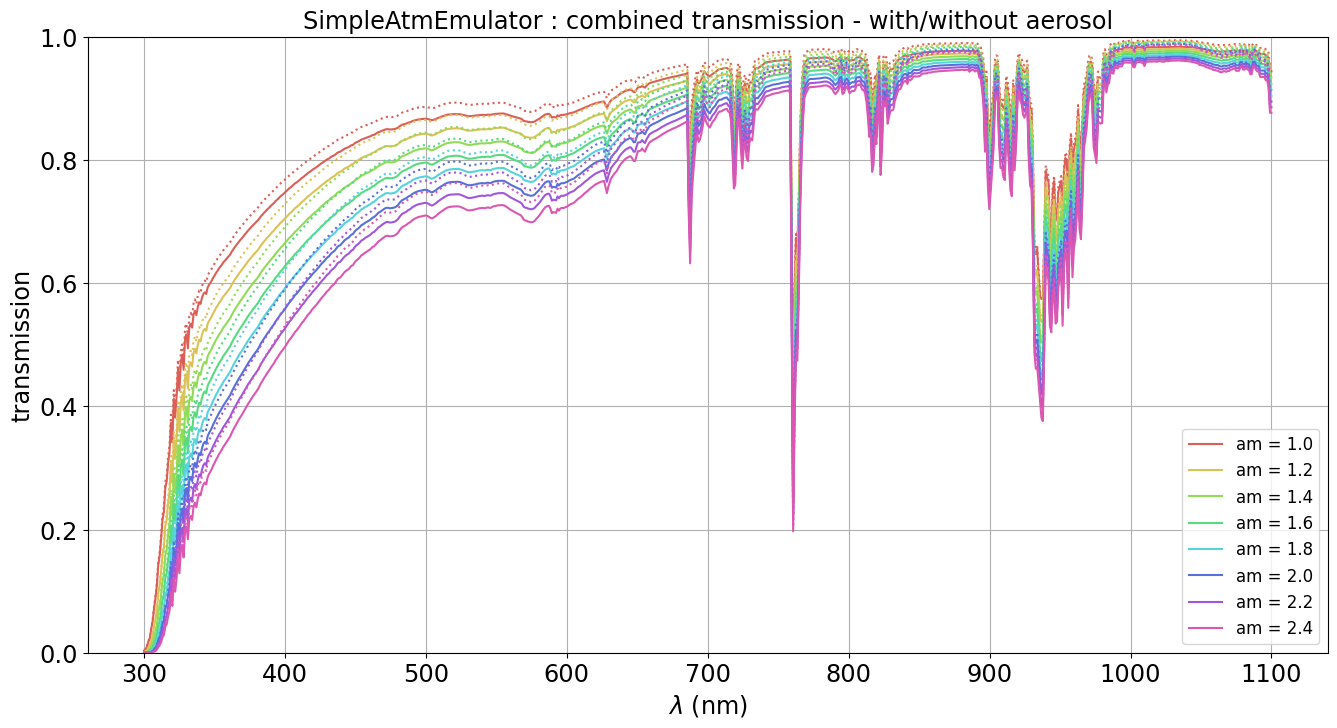

In [33]:
wv0 = 5.0
oz0 = 500.
ncomp=1
taus= [0.02]
betas = [-1]

fig, ax = plt.subplots()

for idx,am in enumerate(airmasses):

    transm = emul.GetAllTransparencies(WL,am,pwv0,oz0,ncomp=ncomp, taus=taus, betas=betas, flagAerosols=True)
    transmnoaer = emul.GetAllTransparencies(WL,am,pwv0,oz0)
    label = f"am = {am:.1f}"
    ax.plot(WL,transm,color=hls_colors[idx],label = label)
    ax.plot(WL,transmnoaer,":",color=hls_colors[idx])
    
ax.set_ylim(0,1)
title = f"SimpleAtmEmulator : combined transmission - with/without aerosol"
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()